In [3]:

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, copysign
from scipy.optimize import brenth
from scipy.optimize import fsolve,fmin_l_bfgs_b,fmin_cg,fminbound


"""
sign of the number
"""
def sign(x):
    if x==0:
        return 0
    else:
        return copysign(1,x)

"""
if function f can't be computed, return None
"""
def f_None(f,x):
    try:
        return f(x)
    except:
        return None

"""
if the bound was touched returns None
L is the level of the function f
"""
def correct(x,y,f,L):
    eps=10e-5
    if abs(f(x,y)-L)>eps:
        return None
    else:
        return y

"""
if output can't be produced, return 0, if there's division by zero, then it looks for the limit and returns it
"""
def _(f,*x):
    try:
        out=f(*x)
        if out is None:
            return float("inf")
        else:
            return out
    except ZeroDivisionError:
        l=len(x)
        eps=abs(f(*[1e-02]*l)-f(*[1e-04]*l))
        if abs(f(*[1e-04]*l)-f(*[1e-06]*l))<eps and abs(f(*[1e-06]*l)-f(*[1e-08]*l))<eps:
            return f(*[1e-10]*l)
        else:
            return sign(f(*[1e-10]*l))*float("inf")

"""
produces the array of the first items of the element of the array
"""
def fst(X):
    return map(lambda x: x[0],X)
"""
produces the array of the second items of the element of the array
"""
def snd(X):
    return map(lambda x: x[1],X)

"""
unpacks [(X_1,Y_1),...,(X_k,Y_k),...,(X_n,Y_n)] into [(X_1,...,X_k,...,X_n),(Y_1,...,Y_k,...,Y_n)]
"""
def unpack(X):
    return [fst(X),snd(X)]

"""
find the root of the function. If the ends of the interval have the same signs, try to make it smaller
"""
def rootalt(f,a,b):
    eps=(b-a)/64.0
    turn=0
    N_iter=10
    while abs(a-b)>eps and N_iter!=0:
        N_iter-=1
        try:
            #return fmin_cg(f,(a+b)/2.0)[0]
            return brenth(f,a,b)
        except ValueError:
            if turn==0:
                a=a+eps
                turn=1
            else:
                b=b+eps
                turn=0
    #return root2(f,a,b)
    return None

def root(f,a,b):
    a_init=a
    b_init=b
    eps=(b-a)/16.0
    turn=0
    N_iter=12
    while abs(a-b)>eps and N_iter!=0 and f(a)*f(b)>0:
        N_iter-=1
        if turn==0:
            a=a+eps
            turn=1
        else:
            b=b-eps
            turn=0
    try:
        return brenth(f,a,b)
    except ValueError:
        return fminbound(f,a_init,b_init)

    
     

def root2(f,a,b):
    return fmin_cg(f,(a+b)/2.0,disp=False)[0]

def root3(f,a,b):
    return fmin_l_bfgs_b(func=f,x0=(a+b)/2,bounds=[a,b])

"""
2-point numerical derivative
"""
def prime(f,dt=10e-3):
    return lambda x: (f(x+dt)-f(x-dt))/(2*dt)

"""
Marginal rate of substitution of a utility function u(.)
"""
def MRS(u):
    u_x=lambda x,y: prime(lambda z: u(z,y))(x)
    u_y=lambda x,y: prime(lambda z: u(x,z))(y)
    return lambda x,y: u_x(x,y)/u_y(x,y)

"""
Edgeworth Box parameter determine that to show on the plot
"""

class EdgeBoxParameter:
    #def __init__(self,pareto,core,U1,U2,endow,walras,budget,N):
        #boll_array=[pareto,core,U1,U2,endow,walras,budget]
    def __init__(self,N,pareto=True,core=True,eq=True,budget=True):
        self.N=N
        self.pareto=pareto
        self.core=core
        self.eq=eq
        self.budget=budget
        
defaultEBP=EdgeBoxParameter(100)        

class EdgeBox():
    def __init__(self,u1,u2,IE1,IE2,EBP=defaultEBP):
        self.core=0
        self.pareto=0
        self.eq=0
        self.p=[None,1]
        self.p_weighted=[None,None]
        self.u1=u1
        self.u2=u2
        self.u2_compl=lambda x,y: u2(self.IE[0]-x,self.IE[1]-y)
        self.IE1=IE1
        self.IE2=IE2
        self.IE=[IE1[0]+IE2[0],IE1[1]+IE2[1]]
        self.EBP=EBP
        self.dt=min(self.IE)/float(EBP.N)
        self.X=np.linspace(self.dt,self.IE[0]-self.dt,EBP.N)
        self.Y=np.linspace(self.dt,self.IE[1]-self.dt,EBP.N)
        self.calc_init()
        self.calc()
    
    def calc(self):
        """
        calculate all solutions of the box
        """
        self.calc_pareto()
        self.calc_core()
        self.calc_eq()
        self.calc_budget()
        
    
    def calc_init(self):
        self.u1(*self.IE1)
        self.UIE1=self.u1(*self.IE1) # utility of the 1-st player at her initial endowment
        self.UIE2=self.u2(*self.IE2) # utility of the 2-nd player at her initial endowment
        self.u_ie_1=lambda x: root(lambda y: self.u1(x,y)-self.UIE1,self.Y[0],self.Y[-1]) # utility function at initial endowment of the 1-st participant
        self.u_ie_2=lambda x: root(lambda y: self.u2(x,y)-self.UIE2,self.Y[0],self.Y[-1])  # utility function at initial endowment of the 2-nd participant
        self.u_ie_2_compl=lambda x: -self.u_ie_2(self.IE[0]-x)+self.IE[1]                   # utility function at initial endowment of the 2-nd participant in terms of the 1-st

        U1=map(lambda x: correct(x,f_None(self.u_ie_1,x),self.u1,self.UIE1),self.X)
        U2=map(lambda x: correct(x,f_None(self.u_ie_2_compl,x),self.u2_compl,self.UIE2),self.X)
        
        self.U1=filter(lambda x: x[0] is not None and x[1] is not None,zip(self.X,U1))
        self.U2=filter(lambda x: x[0] is not None and x[1] is not None,zip(self.X,U2))
        U1_sort=sorted(self.U1,key=lambda x: x[1])
        U2_sort=sorted(self.U2,key=lambda x: x[1])
        if len(U1_sort)>0:
            self.U1_min=U1_sort[0]
            self.U1_max=U1_sort[-1]
        else:
            self.U1_min=None
            self.U1_max=None
        if len(U2_sort)>0:
            self.U2_min=U2_sort[0]
            self.U2_max=U2_sort[-1]
        else:
            self.U2_min=None
            self.U2_max=None
        self._B=lambda x,y,p: y-(p*(self.IE1[0]-x)+self.IE1[1]) # budget constraint 
    
    def calc_pareto(self):
        self.MRS1=MRS(self.u1)
        self.MRS2=MRS(self.u2)
        self._pareto=lambda x: root(lambda y: _(self.MRS1,x,y)-_(self.MRS2,self.IE[0]-x,self.IE[1]-y),self.Y[0],self.Y[-1])
        P=map(lambda x: f_None(self._pareto,x),self.X[1:-1])
        self.PARETO=zip(self.X[1:-1],P)
        self._Bx=lambda x: root(lambda y: self._B(x,y,self.MRS1(x,y)),self.Y[0],self.Y[-1])
        #plot_pareto,=plt.plot(X,P,linewidth=2)
        PU1_X=root(lambda x: _(self._pareto,x)-_(self.u_ie_1,x),self.U1_min[0],self.U1_max[0])
        PU2_X=root(lambda x: _(self._pareto,x)-_(self.u_ie_2_compl,x),self.U2_min[0],self.U2_max[0])
        PU1_Y=self.u_ie_1(PU1_X)
        PU2_Y=self.u_ie_2_compl(PU2_X)
        self.PU1=[PU1_X,PU1_Y]
        self.PU2=[PU2_X,PU2_Y]
        self._Bx=lambda x: root(lambda y: _(self._B,x,y,_(self.MRS1,x,y)),self.Y[0],self.Y[-1])
    
    def calc_core(self):
        CORE_X=filter(lambda x: x>=self.PU1[0] and x<=self.PU2[0], self.X)
        CORE_Y=map(lambda x: self._pareto(x), CORE_X)
        self.CORE=zip(CORE_X,CORE_Y)

    def calc_eq(self):
        EQ_X1=root(lambda x: _(self._pareto,x)-_(self._Bx,x),self.PU1[0],self.PU2[0])
        EQ_Y1=self._pareto(EQ_X1)
        EQ_X2=self.IE[0]-EQ_X1
        EQ_Y2=self.IE[1]-EQ_Y1
        self.EQ1=[EQ_X1,EQ_Y1]
        self.EQ2=[EQ_X2,EQ_Y2]
        self.p=self.MRS1(*self.EQ1)
        self.p_weighted=[self.p/(self.p+1),1/(self.p+1)]
        self.UEQ1=self.u1(*self.EQ1)
        self.UEQ2=self.u2(*self.EQ2)

        self.u_eq_1=lambda x: root(lambda y: self.u1(x,y)-self.UEQ1,self.Y[0],self.Y[-1])
        self.u_eq_2=lambda x: root(lambda y: self.u2(x,y)-self.UEQ2,self.Y[0],self.Y[-1])
        self.u_eq_2_compl=lambda x: -self.u_eq_2(self.IE[0]-x)+self.IE[1]
        
        U1_EQ=map(lambda x: correct(x,f_None(self.u_eq_1,x),self.u1,self.UEQ1),self.X)
        U2_EQ=map(lambda x: correct(x,f_None(self.u_eq_2_compl,x),self.u2_compl,self.UEQ2),self.X)
        self.U1_EQ=filter(lambda x: x[0] is not None and x[1] is not None,zip(self.X,U1_EQ))
        self.U2_EQ=filter(lambda x: x[0] is not None and x[1] is not None,zip(self.X,U2_EQ))
        
    def calc_budget(self,price=None):
        if price is None:
            price=self.p
            
        self.Bp=lambda x: price*self.IE1[0]+self.IE1[1]-price*x
        
        Budget=map(self.Bp,self.X)
        self.BUDGET=zip(self.X,Budget)
        
    
    def plot(self,fname=None):
        plot_endow,=plt.plot(self.IE1[0],self.IE1[1],color="white",marker="o")
        m=max(self.IE[0],self.IE[1])
        plt.axis([0,m,0,m],autoscale=False)
        plot_U1,=plt.plot(*unpack(self.U1),color="blue")
        plot_U2,=plt.plot(*unpack(self.U2),color="brown")
        plot_pareto,=plt.plot(*unpack(self.PARETO),linewidth=2,color="red")
        
        plot_core,=plt.plot(*unpack(self.CORE),color="black",linewidth=4)
        
        plot_U1_EQ,=plt.plot(*unpack(self.U1_EQ),ls='--',color="blue")
        plot_U2_EQ,=plt.plot(*unpack(self.U2_EQ),ls='--',color="brown")
        plot_budget,=plt.plot(*unpack(self.BUDGET),color="green")
        plt.plot(self.PU1[0],self.PU1[1],color="blue",marker="o")
        plt.plot(self.PU2[0],self.PU2[1],color="brown",marker="o")
        plot_walras,=plt.plot(self.EQ1[0],self.EQ1[1],color="green",marker="o")

        # annotation
        plt.annotate("(%s;%s)"%(round(self.EQ1[0],2),round(self.EQ1[1],2)), xy=self.EQ1, xytext=(self.EQ1[0]+self.dt,self.EQ1[1]-self.dt))

        plt.title("Edgeworth Box")
        plt.legend([plot_pareto,plot_U1,plot_U2,plot_endow,plot_core,plot_walras,plot_budget,plot_U1_EQ,plot_U2_EQ]
                   ,["Pareto","U1 before trade","U2 before trade","Init. endow.","Core","Equilibrium","Budget constraint","U1 at eq.","U2 at eq."])
        #Axes Dscription
        plt.xlabel("Units of 1-st good")
        plt.ylabel("Units of 2-nd good")
        if fname is not None:
            plt.savefig(fname)
            plt.close()
        else:
            plt.show(block=False)

In [4]:
EB=EdgeBox(u1=lambda x,y: x**0.6*y**0.4,u2=lambda x,y: x**0.1*y**0.9,IE1=[10,20],IE2=[20,10])

RuntimeError: matplotlib does not support generators as input

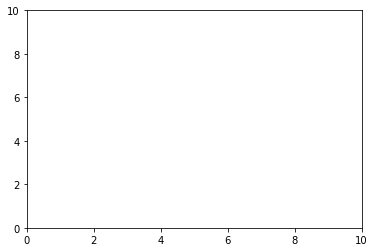

In [8]:
EB2=EdgeBox(u1=lambda x,y: x**2*y,u2=lambda x,y: x+y,IE1=[5,5],IE2=[5,5])
EB2.plot()